# Emission Line Galaxy Classification

This tutorial is based on: https://escip.io/notebooks/emission_line_galaxy_classification_v2.html

## Objectives
- To explore classifying emission line galaxies according to the radiation source excitating gaseous clouds within each galaxy
- To understand how emission line ratios can help constrain excitation mechanisms
- To explore how models can highlight the strengths and weakness of various diagnostic diagrams
- To provide a foundation to explore your own questions about excitation mechanisms in galaxies

## Learning Outcomes
By the end of this tutorial you should be able to:
- Use emission line ratios to explore their diagnostic potential for finding AGN
- Use diagnostic diagrams to demarcate AGN and SF boundaries



In [1]:
# Import relevant libraries

import pandas as pd # data analysis 
import numpy as np # more data analysis
import seaborn as sns # plotting library
from matplotlib import pyplot as plt # another plotting library
from astroquery.sdss import SDSS

In [2]:
# Make notebook have a clean appearance

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

## Choosing a sample of galaxies

GalSpecLine and emissionLinesPort are examples of two schema available to search for emission line galaxies. The most common emission lines are featured in both schema, but there are several lines not cross listed between the two catalogs. The methods used for measuring the emission line strengths differ between the catalogs, each with their unique merits. We will use GalSpecLine for this tutorial, however emissionLinesPort could be used in a follow up project.

While you can include as many or as little emission lines as you’d like in your query, you should always include the emission line flux errors and the galaxy redshifts. The errors on the emission line measurements enable you to improve the quality of your sample if only specific emission lines interest you. It is better to impose these restrictions after your query as it can dramatically reduce the sample size. The redshift of each galaxy is important because certain emission lines will shift into and outside the SDSS window of observation.

The SDSS aperture is fixed in size and is typically aligned with the nuclear center of each galaxy.

- How might the size of the SDSS aperture tie into your ability to discern galaxy wide properties at certain redshifts?
- What sort of bias does this introduce into your results?

In [3]:
# Create a query to generate a sample of galaxies

query = 'SELECT TOP 10000 s.plate, s.fiberid, s.mjd, s.z, s.zwarning, '
query += 'g.oii_3726_flux, g.oii_3729_flux, ' #-- Gather possible emission lines of interest
query += 'g.neiii_3869_flux, g.h_delta_flux, '
query += 'g.h_gamma_flux, g.oiii_4363_flux, '
query += 'g.h_beta_flux, g.oiii_4959_flux, '
query += 'g.oiii_5007_flux, '
query += 'g.oi_6300_flux, g.nii_6548_flux, '
query += 'g.h_alpha_flux, g.nii_6584_flux, '
query += 'g.oii_3726_flux_err, g.oii_3729_flux_err, ' #-- Gather emission line errors
query += 'g.neiii_3869_flux_err, g.h_delta_flux_err, '
query += 'g.h_gamma_flux_err, g.oiii_4363_flux_err, '
query += 'g.h_beta_flux_err, g.oiii_4959_flux_err, '
query += 'g.oiii_5007_flux_err, '
query += 'g.oi_6300_flux_err, g.nii_6548_flux_err, '
query += 'g.h_alpha_flux_err, g.nii_6584_flux_err, '
query += 'e.bptclass '
query += 'FROM GalSpecLine AS g, SpecObj AS s, GalSpecExtra AS e ' 
query += 'WHERE '
query += 's.specobjid = g.specobjid '  # join data tables
query += 'AND s.specobjid = e.specobjid ' # join data tables
query += 'AND z BETWEEN 0.04 and 0.1 '# filter data -- Lower limit needed for global parameters w/ small aperture
query += 'AND h_alpha_flux > h_alpha_flux_err*5 ' #-- Make sure Balmer lines have adequate S/N
query += 'AND h_beta_flux > h_beta_flux_err*5 '
query += 'AND h_alpha_flux_err > 0 ' #-- Consistency check
query += 'AND h_beta_flux_err > 0 '
query += 'AND sigma_balmer < 509.55 ' #-- Exclude the broad line emitting galaxies
query += 'AND s.class = \'GALAXY\' '  #-- Looking for galaxies, not stars
query += 'AND s.zwarning = 0 '
#print (query) # useful for debugging, remove first # to uncomment

# send query to SDSS
gals = SDSS.query_sql(query, data_release=16)

#check result
gals

plate,fiberid,mjd,z,zwarning,oii_3726_flux,oii_3729_flux,neiii_3869_flux,h_delta_flux,h_gamma_flux,oiii_4363_flux,h_beta_flux,oiii_4959_flux,oiii_5007_flux,oi_6300_flux,nii_6548_flux,h_alpha_flux,nii_6584_flux,oii_3726_flux_err,oii_3729_flux_err,neiii_3869_flux_err,h_delta_flux_err,h_gamma_flux_err,oiii_4363_flux_err,h_beta_flux_err,oiii_4959_flux_err,oiii_5007_flux_err,oi_6300_flux_err,nii_6548_flux_err,h_alpha_flux_err,nii_6584_flux_err,bptclass
int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
266,575,51630,0.08577254,0,14.66852,7.437927,3.841347,5.27385,8.785986,-3.978425,21.57409,1.900199,6.008904,5.940429,16.18854,122.9959,48.82838,5.232395,4.753706,3.404466,3.104035,2.739097,2.880512,2.560436,2.571726,2.612152,2.082382,0.7965218,2.828085,2.402491,2
267,37,51608,0.06580772,0,8.157495,13.45847,-2.050378,5.377712,10.32344,-0.4811471,19.97931,4.736043,13.00234,5.895974,18.53547,105.842,55.90726,4.151037,4.343494,3.22041,2.767026,2.398033,2.648729,2.387799,2.479066,2.608933,2.315228,1.037001,3.394915,3.127831,3
267,381,51608,0.08072105,0,14.26086,15.02584,12.85853,9.819148,15.79271,0.6305285,35.01701,4.574448,8.173638,6.321484,21.68835,168.3379,65.41706,6.032469,5.970955,3.768656,3.170219,3.006824,2.964885,3.165485,2.932807,2.864309,2.292617,0.9978625,3.727544,3.00978,2
268,217,51633,0.08504127,0,9.642654,10.31037,4.208603,4.801634,8.102124,0.2046893,18.46765,0.8400924,6.313782,3.516699,10.21538,70.71,30.81195,4.586084,5.430925,2.758277,2.249227,2.208579,2.016458,1.91924,1.873685,1.85732,1.88414,0.7282508,2.330467,2.19657,2
268,242,51633,0.08443944,0,42.09605,62.06191,1.559205,9.3792,17.04971,-0.7318297,41.82759,6.365252,21.72045,5.63995,17.4363,160.1712,52.5919,4.540229,5.138338,2.784199,2.161598,2.173703,2.068914,2.020365,1.816585,2.122846,2.075209,0.566354,2.497444,1.708253,1
268,373,51633,0.06671763,0,13.57658,30.98819,-2.029411,2.905183,11.24041,-0.2474009,24.47227,6.875615,16.18714,3.403676,20.50491,124.2035,61.84755,5.463416,5.911321,3.50536,3.061804,2.903715,3.024822,2.967222,2.948595,3.062814,2.846356,1.161995,3.999935,3.504842,3
268,581,51633,0.09665812,0,54.10457,106.2526,2.216537,16.34068,33.09042,6.189805,92.84365,19.89678,48.29964,18.96861,46.68909,474.5296,140.8251,3.902982,4.210298,2.539174,2.147641,2.144267,2.035393,2.47049,1.991104,2.313466,1.690414,0.7894719,4.570241,2.381227,1
268,584,51633,0.06523123,0,5.218501,8.528907,-1.140014,2.092744,4.079867,1.947302,10.57014,2.130952,3.613952,1.826606,5.872317,37.09188,17.71226,3.02214,3.118422,2.335803,2.0674,1.63301,1.68401,1.473598,1.437225,1.524493,1.050942,0.4798458,1.489082,1.447324,2
268,640,51633,0.09205124,0,52.10047,92.08177,10.2384,15.64311,42.4033,-3.505736,117.4207,49.89558,152.3866,17.51505,88.02023,507.7617,265.4893,5.516428,5.491623,3.323214,2.884278,3.104629,2.664242,3.327506,3.068627,3.77449,2.420078,1.43401,5.96054,4.325299,3


In [4]:
gals.keys()

['plate',
 'fiberid',
 'mjd',
 'z',
 'zwarning',
 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'oii_3726_flux_err',
 'oii_3729_flux_err',
 'neiii_3869_flux_err',
 'h_delta_flux_err',
 'h_gamma_flux_err',
 'oiii_4363_flux_err',
 'h_beta_flux_err',
 'oiii_4959_flux_err',
 'oiii_5007_flux_err',
 'oi_6300_flux_err',
 'nii_6548_flux_err',
 'h_alpha_flux_err',
 'nii_6584_flux_err',
 'bptclass']

## Using emission lines to find active galaxies

Ratios featuring emission lines with relatively different ionization potentials effectively probe the shape of the ionizing radiation field and therefore the excitation source (e.g., starlight, AGN).

As a trial run, let’s explore how well the emission line ratio [O II] 
3727 / [Ne III] 
3869 separates star forming (SF) galaxies and AGN. N.B. [O II] 
3727 is actually the sum of the [O II] 
3726 and [O II] 
3729 doublet.

- What are relavent ionization potentials for [O II] and [Ne III] line emission?
- Would you expect AGN to display higher or lower [O II]/[Ne III] ratios compared to SF galaxies?


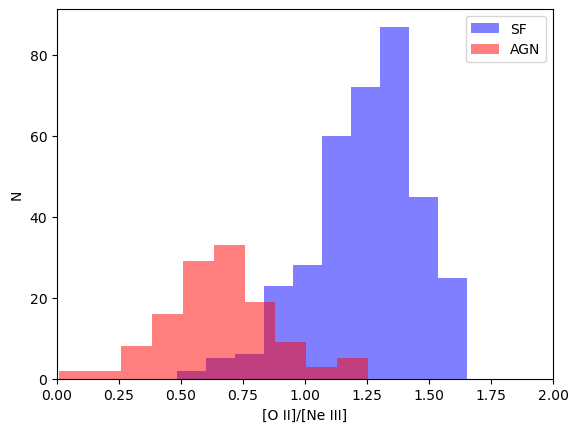

In [5]:
# Remove possible +/- inf values
gals_flux = gals[(gals['neiii_3869_flux']>0) & (gals['oii_3726_flux']>0) & (gals['oii_3729_flux']>0) 
                 & (gals['oi_6300_flux']>0) & (gals['oiii_5007_flux']>0)]

# Make sure relavent emission lines have well measured fluxes
quality_gals = gals_flux[(gals_flux['neiii_3869_flux']>5.0*gals_flux['neiii_3869_flux_err']) &
                (gals_flux['oii_3726_flux']>5.0*gals_flux['oii_3726_flux_err']) &
                (gals_flux['oii_3729_flux']>5.0*gals_flux['oii_3729_flux_err']) &
                (gals_flux['oi_6300_flux']>5.0*gals_flux['oi_6300_flux_err'])]

# Split the sample into AGN and SF galaxies
gals_sf = quality_gals[quality_gals['bptclass']==1]
gals_agn = quality_gals[(quality_gals['bptclass']==4)]

oii_doublet_sf = gals_sf['oii_3726_flux']+gals_sf['oii_3729_flux']
oii_doublet_agn = gals_agn['oii_3726_flux']+gals_agn['oii_3729_flux']

oii_neiii_sf = np.log10(oii_doublet_sf/gals_sf['neiii_3869_flux'])
oii_neiii_agn = np.log10(oii_doublet_agn/gals_agn['neiii_3869_flux'])

plt.hist(oii_neiii_sf,color='blue',alpha=0.5,label='SF')
plt.hist(oii_neiii_agn,color='red',alpha=0.5,label='AGN')
plt.xlim(0.0,2.0)
#plt.title('[O II]/[Ne III] as a function of galaxy classification')
plt.xlabel('[O II]/[Ne III]')
plt.ylabel('N')
plt.legend()
plt.show()

The histogram shows the number of galaxies in each bin as a function of galaxy classification. It is useful in telling us that the $N_{SF} > N_{AGN}$ and that each distribution peaks at a differnt [O II]/[Ne III]. But, the actual location of those peaks is bit uncertain because the histogram is rather blocky.

The Python package matplotlib will try to select a bin width that results in a visually appealing histogram. We can adjust the number of bins, and therefore the bin width, using the “bins” kwarg. However, histograms will always appear bumpy and depend upon the endpoints of the bins. One way around this is to use a Keneral Density Estimator (KDE) plot, which you can read about here: https://towardsdatascience.com/histograms-vs-kdes-explained-ed62e7753f12. 

We can use the “seaborn” package to make publicaton quality KDE plots that show a smooth distribution of our data. The plot now shows the density of galaxies rather than the number of galaxies.

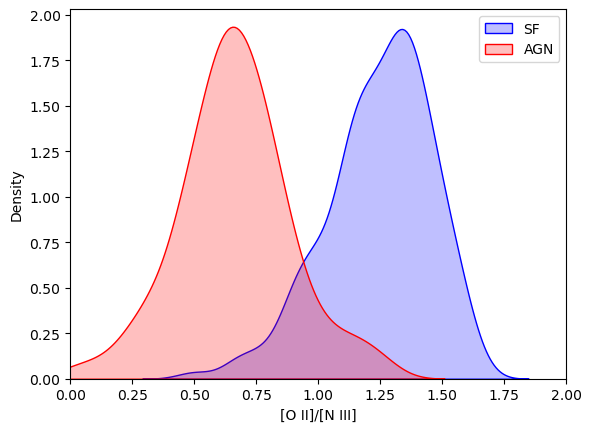

In [6]:
sns.kdeplot(oii_neiii_sf,color='Blue',fill=True,label='SF')
sns.kdeplot(oii_neiii_agn,color='Red',fill=True,label='AGN')
plt.xlim(0.0,2.0)
plt.xlabel('[O II]/[N III]')
plt.ylabel('Density')
plt.legend()
plt.show()

The KDE plot of [O II]/[Ne III] shows that no matter how we slice it, this ratio alone is not capable of separating SF and AGN excitation in galaxies. Let’s assess the ability of [O III] $\lambda$5007 /[O I] $\lambda$6300 to act as an effective excitation diagnostic. Try generating a KDE plot for this emission line ratio in the space below and ask yourself the following questions.

- What are relavent ionization potentials for [O III] and [O I] line emission?
- Would you expect AGN to display higher or lower [O III]/[O I] ratios compared to SF galaxies?
- Can you make a single cut to separate all galaxies with an AGN from those only experiencing SF?

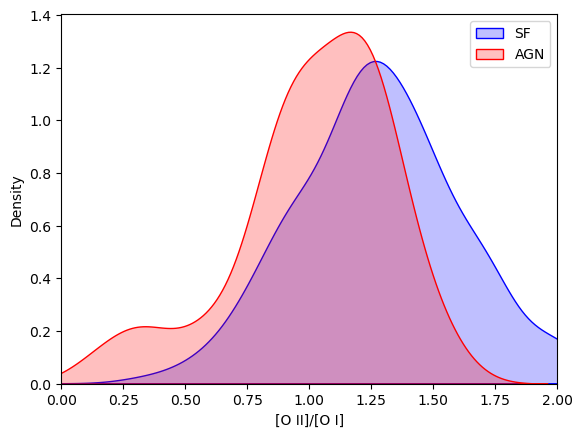

In [7]:
oiii_oi_sf = np.log10(gals_sf['oiii_5007_flux']/gals_sf['oi_6300_flux'])
oiii_oi_agn = np.log10(gals_agn['oiii_5007_flux']/gals_agn['oi_6300_flux'])

sns.kdeplot(oiii_oi_sf,color='Blue',fill=True,label='SF')
sns.kdeplot(oiii_oi_agn,color='Red',fill=True,label='AGN')
plt.xlim(0.0,2.0)
plt.xlabel('[O II]/[O I]')
plt.ylabel('Density')
plt.legend()
plt.show()

## Diagnostic Diagrams

We can combine multiple line ratios in a diagram to increase their utility in separating AGN and SF activity. This assesses the shape of the inicident radiation field (starlight or AGN) at more energies than possible with a single emission line ratio. Let’s combine [O II]/[Ne III] and [O III]/[O I] into a single plot.

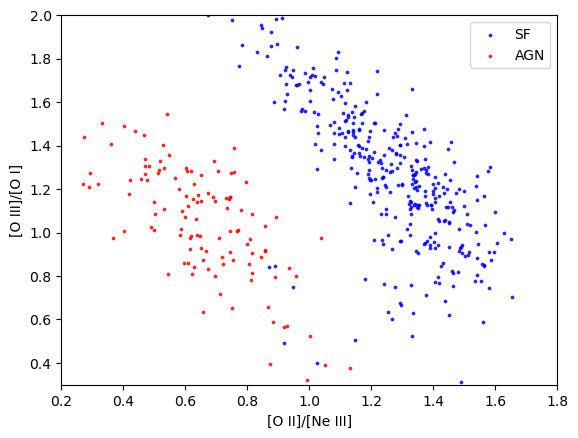

In [8]:
plt.scatter(oii_neiii_sf, oiii_oi_sf, color='blue', label='SF', s=3, alpha=0.75)
plt.scatter(oii_neiii_agn, oiii_oi_agn, color='red',label='AGN', s=3, alpha=0.75)

plt.xlabel('[O II]/[Ne III]')
plt.ylabel(r'[O III]/[O I]')

plt.xlim(0.2,1.8)
plt.ylim(0.3,2.0)

plt.legend()

plt.show()

## Adding AGN/SF demarcations

The [O III]/[O I] vs. [O II]/[Ne III] diagram does a reasonable job in separating AGN and SF galaxies. We can make this separation more explicit by adding a demarcation line. Since we might want to generate this plot over and over, we can make define a function that will do it for us.

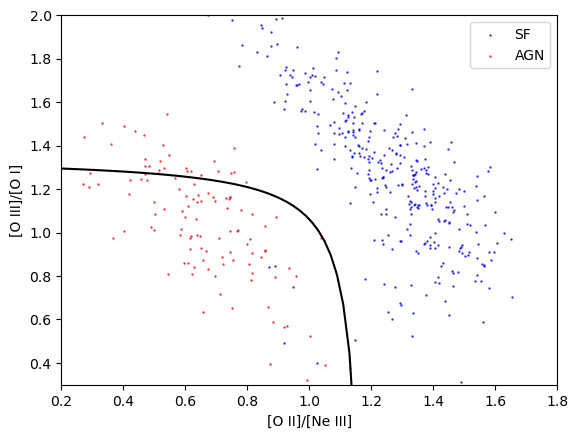

In [9]:
def make_diagram():

    o2ne3_demarc = np.linspace(0.2, 1.19)
    o3o1_demarc = (0.055 / (o2ne3_demarc - 1.19)) + 1.35

    plt.scatter(oii_neiii_sf,oiii_oi_sf,color='blue',label='SF',s=0.5,alpha=0.75)
    plt.scatter(oii_neiii_agn,oiii_oi_agn,color='red',label='AGN',s=0.5,alpha=0.75)

    plt.plot(o2ne3_demarc,o3o1_demarc,'k')

    plt.xlabel('[O II]/[Ne III]')
    plt.ylabel(r'[O III]/[O I]')

    plt.xlim(0.2,1.8)
    plt.ylim(0.3,2.0)

    plt.legend()

######    

make_diagram()
plt.show()

## The BPT Diagram

The diagnostic diagram that we have developed does have it’s limitations. For example, both of the [O II] and [Ne III] emission lines are unavailable for low-z galaxies because they fall outside the SDSS observing window. This means that we’re unable to identify AGN activity for local galaxies. Another limitation is that some of the emission lines can be rather weak, making a reliable detection difficult. We can quantify this by looking at much our sample reduces down after applying our S/N cut.

In [10]:
print ('Fraction of initial SF galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_sf)/len(gals[gals['bptclass']==1])))
print ('Fraction of initial AGN galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_agn)/len(gals[gals['bptclass']==4])))

Fraction of initial SF galaxies included after S/N cut:  0.0618
Fraction of initial AGN galaxies included after S/N cut:  0.246


Therein lies the problem: most galaxies only have a handful of reliable emission lines measurements. This is one reason why the diagnostic diagram we have been analyzing isn’t a popular choice in research literature even though it does a reasonable job of distinguishing between AGN and star forming galaxies.

The so-called “gold standard” for classifying AGN with optical spectroscopy is known as the <b>“BPT” diagram </b>, named after the authors that developed it in this paper. The BPT diagram uses emission line ratios from [O III] 
$\lambda$5007, [N II] 
$\lambda$6584, H$\beta$
, and H$\alpha$
, all of which are known as “strong lines” since they’re strong enough to be reliably measured in most galaxies. Using strong lines for diagnostics drastically improves the number of galaxies we can include in a sample.

In [11]:
gals_flux = gals[(gals['oiii_5007_flux']>0) & (gals['nii_6584_flux']>0)]

quality_gals = gals_flux[(gals_flux['oiii_5007_flux']>5.0*gals_flux['oiii_5007_flux_err']) &
                (gals_flux['nii_6584_flux']>5.0*gals_flux['nii_6584_flux_err'])]

gals_sf = quality_gals[quality_gals['bptclass']==1 | (quality_gals['bptclass']==2)]
gals_agn = quality_gals[(quality_gals['bptclass']==4)]

print ('Fraction of initial SF galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_sf)/len(gals[gals['bptclass']==1])))
print ('Fraction of initial AGN galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_agn)/len(gals[gals['bptclass']==4])))

Fraction of initial SF galaxies included after S/N cut:  0.961
Fraction of initial AGN galaxies included after S/N cut:  0.998


The BPT diagram remains an important topic in academic literature today. In fact, the GalSpecExtra schema actually uses the BPT diagram to classify galaxies as AGN or star forming. If we use the standard demarcations from literature, it is no surprise in the plot the below that all of the AGN and star forming galaxies are perfectly separated. 

There is even an additional class of galaxies known as “composites” that are thought to represent a transition state between purly star forming galaxies and those excited purely by an AGN.

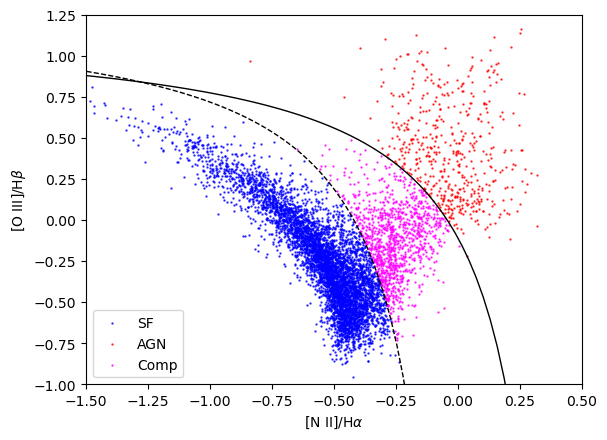

In [12]:
def make_bpt_plot():
    
    gals_comp = quality_gals[(quality_gals['bptclass']==3)]

    oiii_Hb_sf = np.log10(gals_sf['oiii_5007_flux']/gals_sf['h_beta_flux'])
    oiii_Hb_agn = np.log10(gals_agn['oiii_5007_flux']/gals_agn['h_beta_flux'])
    oiii_Hb_comp = np.log10(gals_comp['oiii_5007_flux']/gals_comp['h_beta_flux'])

    nii_Ha_sf = np.log10(gals_sf['nii_6584_flux']/gals_sf['h_alpha_flux'])
    nii_Ha_agn = np.log10(gals_agn['nii_6584_flux']/gals_agn['h_alpha_flux'])
    nii_Ha_comp = np.log10(gals_comp['nii_6584_flux']/gals_comp['h_alpha_flux'])

    plt.scatter(nii_Ha_sf,oiii_Hb_sf,color='blue',label='SF',s=0.5,alpha=0.75)
    plt.scatter(nii_Ha_agn,oiii_Hb_agn,color='red',label='AGN',s=0.5,alpha=0.75)
    plt.scatter(nii_Ha_comp,oiii_Hb_comp,color='magenta',label='Comp',s=0.5,alpha=0.75)

    comp_n2ha = np.linspace(-2.5,-0.1,100)
    comp_o3hb = 0.61/(comp_n2ha-0.05)+1.3
    plt.plot(comp_n2ha,comp_o3hb,color='k',linestyle='--',linewidth=1.0)

    agn_n2ha = np.linspace(-2.5,0.3,100)
    agn_o2hb = 0.61/(agn_n2ha-0.47)+1.19
    plt.plot(agn_n2ha,agn_o2hb,color='k',linewidth=1.0)

    plt.xlabel(r'[N II]/H$\alpha$')
    plt.ylabel(r'[O III]/H$\beta$')

    plt.xlim(-1.5,0.5)
    plt.ylim(-1.0,1.25)

    plt.legend()

######
    
make_bpt_plot()
plt.show()

All of the strong lines on the BPT diagram fall within the SDSS observation window for both local galaxies and those at higher redshifts. Combined with the superior statistics shown above, this makes the BPT diagram a suitable choice for tracing galaxy evolution. 

There is some differences in the Data set. How obtain the same Data set?